# This is code for a model with classification task, of classifying 'spam' and 'not spam' mails.

**Here we explained about the code stepwise, for more detailed information, please see the report**

In [1]:
# Importting neccesary libraries
import torch as t
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec

from torch import nn
from torch import optim
from sklearn.metrics import precision_score, recall_score, f1_score


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading the data
df=pd.read_csv('spam_or_not_spam.csv')
print(df.count())

email    2999
label    3000
dtype: int64


**Preprocessing**

In [3]:

# step 1 - Remove nan values
index=df.index[~df.email.notnull()].values
for i in index:
    df = df.drop(i)
print(df.count())

# step 2 - check count of spam and not spam, if they are very much different, downsample or upsample them
print(df[df.label==1].count())
print(df[df.label==0].count())

# down sample the size of not spam(2500) to size of spam(500)
df2=df[df.label==0].sample(df[df.label==1].count().values[0]+2)
df3=pd.concat([df2,df[df.label==1]],axis=0)

# shuffle the datapoints
df3=df3.sample(df3.count().values[0])


# step 3- convert the emails to list of texts
inputTextDataArray=df3['email'].values
inputTextData=[]
for i in range(inputTextDataArray.shape[0]):
        inputTextData.append(inputTextDataArray[i].split(' '))
    

email    2999
label    2999
dtype: int64
email    499
label    499
dtype: int64
email    2500
label    2500
dtype: int64


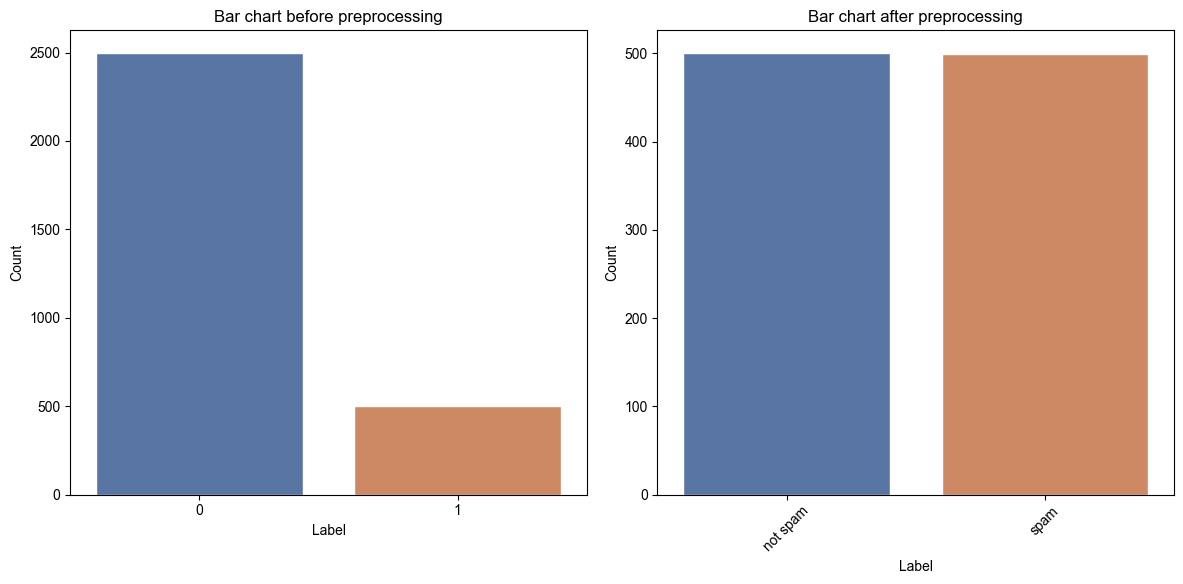

In [4]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set the plot style
sns.set(style="darkgrid")

label_counts = df['label'].value_counts()
# Plot the bar chart for 'spam' and 'not spam' labels in the first subplot
sns.countplot(x='label', data=df, order=label_counts.index, ax=axes[0])
plt.xticks(ticks=[0, 1], labels=['not spam', 'spam'], rotation=45)
axes[0].set_title('Bar chart before preprocessing')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

label_counts = df3['label'].value_counts()
# Plot the bar chart for 'spam' and 'not spam' labels in the second subplot
sns.countplot(x='label', data=df3, order=label_counts.index, ax=axes[1])
axes[1].set_title('Bar chart after preprocessing')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['not spam', 'spam'], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [5]:
# defining the train size, test size, and size of the word2Vec model
testSize=200
trainSize=800
word2VecSize=50

In [6]:

# Create a list of sentences to train the Word2Vec model
sentences =inputTextData[:trainSize]

# Train the Word2Vec model
modelVec =Word2Vec(sentences, vector_size=word2VecSize, min_count=1, workers=4)


In [7]:
# a function whihc finds a vector for given a sentence, by averaging out the vectors
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# a variable storing the vectorial representations of the emails
vectorized_emails = [average_word_vectors(email.split(), modelVec, word2VecSize)
                        for email in df3['email']]

# The labels for the training of the Neural Network
labelsTrain=df3['label'].values.tolist()[:trainSize]

# A Neural network, which takes a vector(the word embeddings) and returns two variables each correspoinding to each of the labels
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(word2VecSize, 30)
        self.hidden_layer2 = nn.Linear(30, 5)
        self.output_layer = nn.Linear(5, 2)
        
        nn.init.xavier_uniform_(self.hidden_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, userInput):
        hidden = self.hidden_layer(userInput)
        hidden = t.relu(hidden)
        hidden2 = self.hidden_layer2(hidden)
        hidden2 = t.relu(hidden2)
        output = self.output_layer(hidden2)
        return output


modelNN = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelNN.parameters(), lr=0.00005)
num_epochs = 100
TrainLossAfterEachEpoch=[]
# Set the model in training mode
modelNN.train()  

for epoch in range(num_epochs):
    for i in range(0, trainSize):
        # Forward pass
        output_logits = modelNN.forward(t.from_numpy(vectorized_emails[i]))
        if labelsTrain[i] == 0:
            target = t.tensor([1.0,0.0], dtype=t.float)
        elif labelsTrain[i] == 1:
            target = t.tensor([0.0,1.0], dtype=t.float)
            
        loss = criterion(output_logits, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    TrainLossAfterEachEpoch.append(loss.item())
# Set the model in evaluation mode
modelNN.eval()  

NeuralNetwork(
  (hidden_layer): Linear(in_features=50, out_features=30, bias=True)
  (hidden_layer2): Linear(in_features=30, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=2, bias=True)
)

**Testing the model with evaluation metrics**

In [8]:
# testing :
LabelSet=df3['label'].values.tolist()[0:trainSize+testSize]
misclassified=0
labelsPred=[]
for i in range(trainSize,trainSize+testSize):
    z=modelNN.forward(t.from_numpy(vectorized_emails[i]))
    label=0
    if(z[0]<z[1]): label=1
    if(label!=LabelSet[i]): misclassified+=1
    labelsPred.append(label)


misclassifiedtrained=0
for i in range(0,trainSize):
    z=modelNN.forward(t.from_numpy(vectorized_emails[i]))
    label=0
    if(z[0]<z[1]): label=1
    if(label!=LabelSet[i]): misclassifiedtrained+=1

        
y_true =LabelSet[trainSize:trainSize+testSize]
y_pred = labelsPred

# calculating the precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)

print(f'Train accuracy is {(1-misclassifiedtrained/trainSize)*100}%')
print(f'Test accuracy is {(1-misclassified/testSize)*100}%')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Train accuracy is 90.5%
Test accuracy is 89.5%
Precision: 0.9042553191489362
Recall: 0.8762886597938144
F1 Score: 0.8900523560209425


**ploting the training loss v/s epochs**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


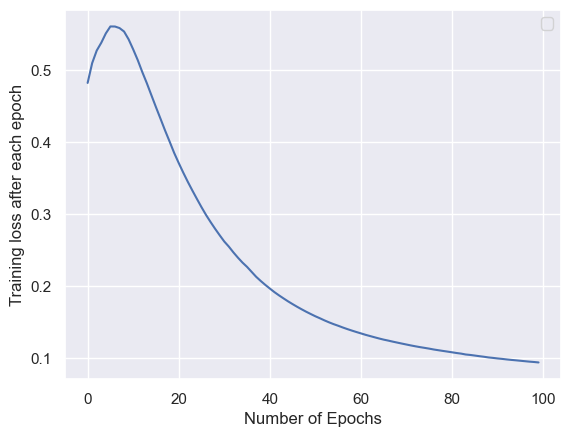

In [9]:
n=np.arange(0,num_epochs)
plt.plot(n,TrainLossAfterEachEpoch)
plt.xlabel('Number of Epochs')
plt.ylabel('Training loss after each epoch')
plt.legend()
plt.show()

**Plotting precesion,recall,f1 score**

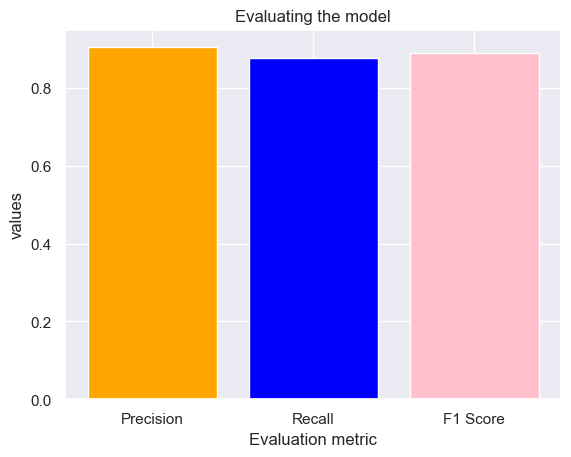

In [10]:
import matplotlib.pyplot as plt

variables = ['Precision', 'Recall', 'F1 Score']

values = [precision, recall, f1_score]
colors=['orange','blue','pink']
plt.bar(variables, values,color=colors)
plt.xlabel('Evaluation metric')
plt.ylabel('values')
plt.title('Evaluating the model')
plt.show()

**Conclusion:**
*Here we used the model word2vec for our task, we can use other models like glove,bert,etc for the same task*

In [11]:
# text='work is workship'
# a=average_word_vectors(text.split(), modelVec, word2VecSize)
# z=modelNN.forward(t.from_numpy(a))
# label=0
# if(z[0]<z[1]): label=1
# print(label,z)
